<a href="https://colab.research.google.com/github/Fuhui-Chen/Fastbook-Practice/blob/master/05_pet_breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Dogs and Cats to Pet Breeds

In [1]:
pip install fastai2

     |████████████████████████████████| 194kB 3.4MB/s 


In [2]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)

To see what is in our dataset we can use the ls method:

In [0]:

#hide
Path.BASE_PATH = path

In [4]:

path.ls()

(#2) [Path('images'),Path('annotations')]

see what's inside the images directory

In [5]:
(path/"images").ls()

(#7393) [Path('images/english_setter_99.jpg'),Path('images/samoyed_36.jpg'),Path('images/Egyptian_Mau_108.jpg'),Path('images/British_Shorthair_188.jpg'),Path('images/Persian_228.jpg'),Path('images/samoyed_120.jpg'),Path('images/english_cocker_spaniel_74.jpg'),Path('images/Egyptian_Mau_52.jpg'),Path('images/British_Shorthair_223.jpg'),Path('images/japanese_chin_177.jpg')...]

In [0]:
fname = (path/"images").ls()[0]

 use the findall method to try a regular expression against the filename of the fname object:

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['english_setter']

Now that we confirmed the regular expression works for the example, let's use it to label the whole dataset. fastai comes with many classes to help with labeling. For labeling with regular expressions, we can use the RegexLabeller class. In this example we use the data block API we saw in <

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


# Presizing
To implement this process in fastai you use Resize as an item transform with a large size, and RandomResizedCrop as a batch transform with a smaller size. RandomResizedCrop will be added for you if you include the min_scale parameter in your aug_transforms function, as was done in the DataBlock call in the previous section. Alternatively, you can use pad or squish instead of crop (the default) for the initial Resize.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


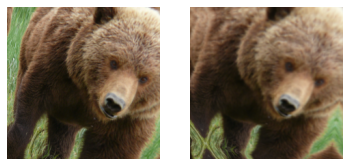

In [11]:
#hide_input
#id interpolations
#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

You can see that the image on the right is less well defined and has reflection padding artifacts in the bottom-left corner; also, the grass iat the top left has disappeared entirely. We find that in practice using presizing significantly improves the accuracy of models, and often results in speedups too.


# Checking and Debugging a DataBlock
We can never just assume that our code is working perfectly. Writing a DataBlock is just like writing a blueprint. You will get an error message if you have a syntax error somewhere in your code, but you have no guarantee that your template is going to work on your data source as you intend. So, before training a model you should always check your data. You can do this using the show_batch method:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


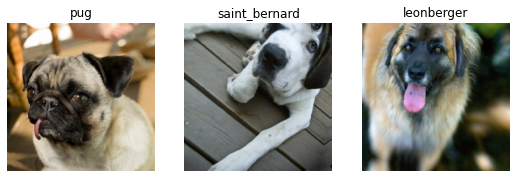

In [13]:
dls.show_batch(nrows=1, ncols=3)

Once you think your data looks right, we generally recommend the next step should be using to train a simple model. We often see people put off the training of an actual model for far too long. As a result, they don't actually find out what their baseline results look like. Perhaps your probem doesn't need lots of fancy domain-specific engineering. Or perhaps the data doesn't seem to train the model all. These are things that you want to know as soon as possible. For this initial test, we'll use the same simple model that we used in <

In [14]:

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.557703,0.354067,0.107578,01:23


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,error_rate,time
0,0.519105,0.305692,0.094723,01:31
1,0.330138,0.217638,0.064276,01:31


As we've briefly discussed before, the table shown when we fit a model shows us the results after each epoch of training. Remember, an epoch is one complete pass through all of the images in the data. The columns shown are the average loss over the items of the training set, the loss on the validation set, and any metrics that we requested—in this case, the error rate.

Remember that loss is whatever function we've decided to use to optimize the parameters of our model. But we haven't actually told fastai what loss function we want to use. So what is it doing? fastai will generally try to select an appropriate loss function based on what kind of data and model you are using. In this case we have image data and a categorical outcome, so fastai will default to using cross-entropy loss.

# Cross-Entropy Loss
Cross-entropy loss is a loss function that is similar to the one we used in the previous chapter, but (as we'll see) has two benefits:

It works even when our dependent variable has more than two categories.
It results in faster and more reliable training.
In order to understand how cross-entropy loss works for dependent variables with more than two categories, we first have to understand what the actual data and activations that are seen by the loss function look like.

# Viewing Activations and Labels
Let's take a look at the activations of our model. To actually get a batch of real data from our DataLoaders, we can use the one_batch method

In [0]:
x,y = dls.one_batch()

In [16]:

y

TensorCategory([26,  8, 36,  0,  1, 15, 34, 25,  5, 13, 24,  6, 35, 32, 33, 30, 25,  2,
        21, 20,  1,  1, 28,  9, 34, 12,  9, 11, 23, 12, 15, 21, 27, 27,  2, 17,
        33, 11, 28, 16, 23, 29,  5,  6, 36, 12, 32, 27, 29,  2, 28, 15, 22, 13,
        10,  4, 28, 33, 36, 13, 10,  8,  4, 25], device='cuda:0')

Our batch size is 64, so we have 64 rows in this tensor. Each row is a single integer between 0 and 36, representing our 37 possible pet breeds. We can view the predictions (that is, the activations of the final layer of our neural network) using Learner.get_preds. This function either takes a dataset index (0 for train and 1 for valid) or an iterator of batches. Thus, we can pass it a simple list with our batch to get our predictions. It returns predictions and targets by default, but since we already have the targets, we can effectively ignore them by assigning to the special variable _:

In [17]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.3529e-04, 2.9348e-06, 3.4630e-07, 1.0195e-04, 3.3200e-06, 6.6842e-06,
        5.9249e-07, 8.6702e-08, 4.4461e-07, 1.4199e-05, 5.5767e-06, 1.4588e-04,
        2.2624e-06, 5.0242e-04, 2.3415e-07, 1.5700e-05, 3.0372e-05, 2.2620e-02,
        1.5540e-06, 4.0730e-06, 3.4296e-05, 2.1996e-07, 5.7920e-07, 2.1197e-06,
        3.4226e-06, 1.7941e-07, 9.7612e-01, 1.5395e-07, 4.8304e-05, 4.1342e-05,
        2.7153e-07, 1.7710e-06, 7.0685e-06, 1.9308e-05, 1.0525e-04, 8.5091e-07,
        1.6660e-05])

The actual predictions are 37 probabilities between 0 and 1, which add up to 1 in total:

In [18]:

len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

# Softmax
In our classification model, we use the softmax activation function in the final layer to ensure that the activations are all between 0 and 1, and that they sum to 1.

Softmax is similar to the sigmoid function, which we saw earlier. As a reminder sigmoid looks like this:

before using plot function, we must define it or we can import utils from fastbook

In [19]:
pip install nbdev

     |████████████████████████████████| 51kB 1.8MB/s 


In [20]:
pip install ipywidgets

In [21]:
pip install pandas

In [22]:
 pip install azure-cognitiveservices-search-imagesearch

     |████████████████████████████████| 51kB 1.8MB/s 
     |████████████████████████████████| 92kB 5.2MB/s 
     |████████████████████████████████| 40kB 4.3MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 2.7MB 29.2MB/s 


In [23]:
!git clone https://github.com/fastai/fastbook

Cloning into 'fastbook'...
remote: Enumerating objects: 1564, done.
remote: Total 1564 (delta 0), reused 0 (delta 0), pack-reused 1564
Receiving objects: 100% (1564/1564), 69.93 MiB | 33.79 MiB/s, done.
Resolving deltas: 100% (901/901), done.


In [0]:
from fastbook.utils import *

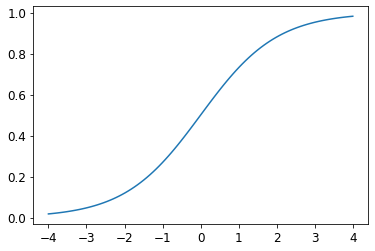

In [25]:
plot_function(torch.sigmoid, min=-4,max=4)

In [0]:

#hide
torch.random.manual_seed(42);

In [27]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We can't just take the sigmoid of this directly, since we don't get rows that add to 1 (i.e., we want the probability of being a 3 plus the probability of being a 7 to add up to 1):

In [28]:

acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [29]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])


Let's check that softmax returns the same values as sigmoid for the first column, and those values subtracted from 1 for the second column:

In [30]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

# Log Likelihood
In the binary case, we used torch.where to select between inputs and 1-inputs. When we treat a binary classification as a general classification problem with two categories, it actually becomes even easier, because (as we saw in the previous section) we now have two columns, containing the equivalent of inputs and 1-inputs. So, all we need to do is select from the appropriate column. Let's try to implement this in PyTorch. For our synthetic 3s and 7s example, let's say these are our labels:

In [0]:
targ = tensor([0,1,0,1,1,0])


and these are the softmax activations:

In [32]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Then for each item of targ we can use that to select the appropriate column of sm_acts using tensor indexing, like so:

In [33]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

To see exactly what's happening here, let's put all the columns together in a table. Here, the first two columns are our activations, then we have the targets, the row index, and finally the result shown immediately above:

In [34]:
#hide_input
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


PyTorch provides a function that does exactly the same thing as sm_acts[range(n), targ] (except it takes the negative, because when applying the log afterward, we will have negative numbers), called nll_loss (NLL stands for negative log likelihood):

In [35]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [36]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

# Taking the Log
The function we saw in the previous section works quite well as a loss function, but we can make it a bit better. The problem is that we are using probabilities, and probabilities cannot be smaller than 0 or greater than 1. That means that our model will not care whether it predicts 0.99 or 0.999. Indeed, those numbers are so close together—but in another sense, 0.999 is 10 times more confident than 0.99. So, we want to transform our numbers between 0 and 1 to instead be between negative infinity and infinity. There is a mathematical function that does exactly this: the logarithm (available as torch.log). It is not defined for numbers less than 0, and looks like this:

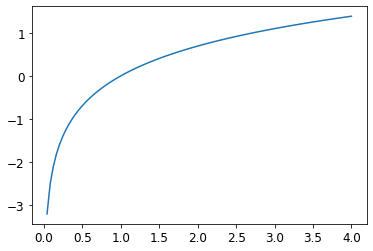

In [37]:
plot_function(torch.log, min=0,max=4)

When we first take the softmax, and then the log likelihood of that, that combination is called cross-entropy loss. In PyTorch, this is available as nn.CrossEntropyLoss (which, in practice, actually does log_softmax and then nll_loss):

In [0]:
loss_func = nn.CrossEntropyLoss()

In [39]:
loss_func(acts, targ)

tensor(1.8045)

All PyTorch loss functions are provided in two forms, the class just shown above, and also a plain functional form, available in the F namespace:

In [40]:

F.cross_entropy(acts, targ)

tensor(1.8045)

By default PyTorch loss functions take the mean of the loss of all items. You can use reduction='none' to disable that:

In [41]:

nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])


# Model Interpretation
It's very hard to interpret loss functions directly, because they are designed to be things computers can differentiate and optimize, not things that people can understand. That's why we have metrics. These are not used in the optimization process, but just to help us poor humans understand what's going on. In this case, our accuracy is looking pretty good already! So where are we making mistakes?

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


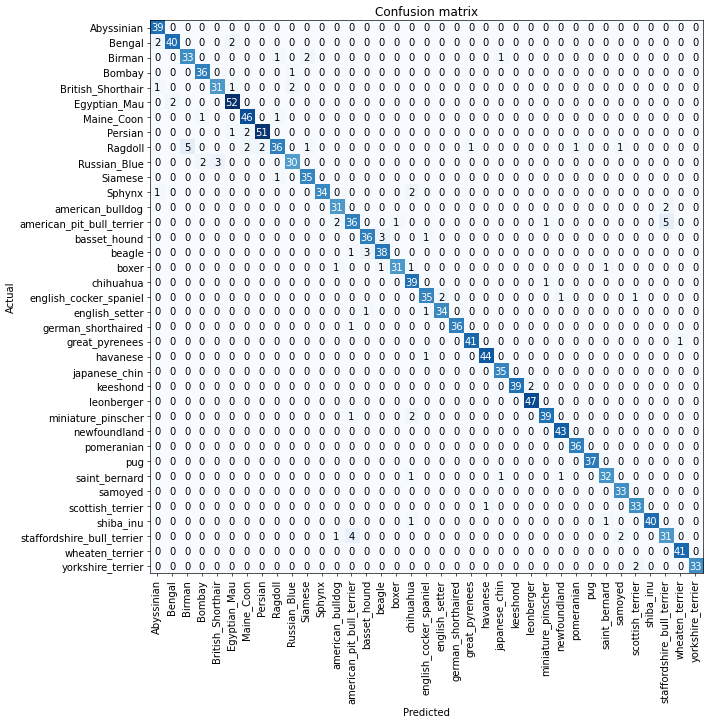

In [42]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

in this case, a confusion matrix is very hard to read. We have 37 different breeds of pet, which means we have 37×37 entries in this giant matrix! Instead, we can use the most_confused method, which just shows us the cells of the confusion matrix with the most incorrect predictions (here, with at least 5 or more):

In [43]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5)]

Since we are not pet breed experts, it is hard for us to know whether these category errors reflect actual difficulties in recognizing breeds. So again, we turn to Google. A little bit of Googling tells us that the most common category errors shown here are actually breed differences that even expert breeders sometimes disagree about. So this gives us some comfort that we are on the right track.

We seem to have a good baseline. What can we do now to make it even better?


# Improving Our Model
We will now look at a range of techniques to improve the training of our model and make it better. While doing so, we will explain a little bit more about transfer learning and how to fine-tune our pretrained model as best as possible, without breaking the pretrained weights.

The first thing we need to set when training a model is the learning rate. We saw in the previous chapter that it needs to be just right to train as efficiently as possible, so how do we pick a good one? fastai provides a tool for this.

# The Learning Rate Finder
One of the most important things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model. Not only does this waste time, but it also means that we may have problems with overfitting, because every time we do a complete pass through the data, we give our model a chance to memorize it.

So let's just make our learning rate really high, right? Sure, let's try that and see what happens:

In [44]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.776412,3.388443,0.438430,01:47


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,error_rate,time
0,3.402308,1.772353,0.521651,02:20



That doesn't look good. Here's what happened. The optimizer stepped in the correct direction, but it stepped so far that it totally overshot the minimum loss. Repeating that multiple times makes it get further and further away, not closer and closer!

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the learning rate finder. His idea was to start with a very, very small learning rate, something so small that we would never expect it to be too big to handle. We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
The last point where the loss was clearly decreasing
The learning rate finder computes those points on the curve to help you. Both these rules usually give around the same value. In the first chapter, we didn't specify a learning rate, using the default value from the fastai library (which is 1e-3):

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


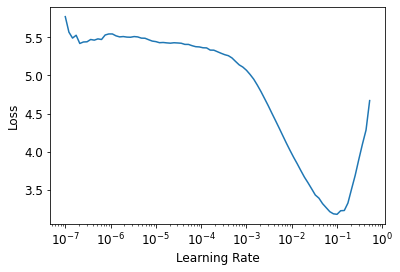

In [45]:

learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [46]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 5.25e-03


We can see on this plot that in the range 1e-6 to 1e-3, nothing really happens and the model doesn't train. Then the loss starts to decrease until it reaches a minimum, and then increases again. We don't want a learning rate greater than 1e-1 as it will give a training that diverges like the one before (you can try for yourself), but 1e-1 is already too high: at this stage we've left the period where the loss was decreasing steadily.

In this learning rate plot it appears that a learning rate around 3e-3 would be appropriate, so let's choose that:

In [47]:

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.324142,0.331935,0.108931,01:47


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,error_rate,time
0,0.547768,0.423826,0.125169,02:20
1,0.366139,0.249746,0.082544,02:21


# Unfreezing and Transfer Learning

In [0]:
learn.fine_tune??

In [49]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.113306,0.337195,0.102165,01:48
1,0.512971,0.248199,0.083897,01:48
2,0.302300,0.227998,0.070365,01:47


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



Then we'll unfreeze the model:

In [0]:
learn.unfreeze()


and run lr_find again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=1.0964781722577754e-06)

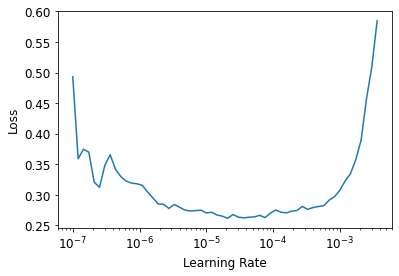

In [51]:
learn.lr_find()

Let's train at a suitable learning rate:

In [52]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.251384,0.220482,0.069689,02:20
1,0.232797,0.213301,0.074425,02:21
2,0.226578,0.209438,0.071719,02:20
3,0.200954,0.199653,0.067659,02:20
4,0.185272,0.199692,0.069689,02:20
5,0.164949,0.201370,0.073072,02:20


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


# Discriminative Learning Rates

In [53]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.143851,0.332258,0.112314,01:48
1,0.523223,0.252584,0.078484,01:48
2,0.309631,0.222148,0.075101,01:48


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,error_rate,time
0,0.269116,0.216609,0.075778,02:20
1,0.252937,0.211390,0.073072,02:20
2,0.230344,0.201073,0.067659,02:20
3,0.197951,0.203079,0.071719,02:20
4,0.203320,0.191049,0.064276,02:20
5,0.156729,0.191469,0.067659,02:20
6,0.151572,0.187784,0.066982,02:20
7,0.135344,0.189408,0.069012,02:20
8,0.126903,0.191092,0.066982,02:22
9,0.122186,0.183504,0.066982,02:20


Now the fine-tuning is working great!

fastai can show us a graph of the training and validation loss:

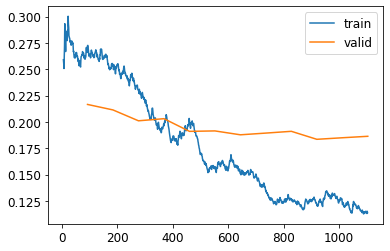

In [54]:
learn.recorder.plot_loss()

# Deeper Architectures

try a ResNet-50 now with mixed precision:

In [55]:

from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.433406,0.310110,0.096076,02:05
1,0.592189,0.295584,0.089986,02:05
2,0.432588,0.310684,0.100135,02:06


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,error_rate,time
0,0.248021,0.282632,0.081867,02:46
1,0.302939,0.428260,0.115020,02:48
2,0.250296,0.266929,0.079161,02:47
3,0.157311,0.257088,0.073072,02:47
4,0.092485,0.201963,0.063599,02:47
5,0.060538,0.197293,0.057510,02:47
